### Import & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
from pathlib import Path
project_dir = Path().resolve().parent
sys.path.append(str(project_dir))

In [3]:
from pipeline import run_pipeline

from data.db_utils import get_connection

from streamlit_app.plot_signals import plot_signals, plot_recent_signals

from backtest.backtest import PandasSignalData, run_backtest, print_bt_evals
from backtest.strategies import AtrDynamicStopStrategy, AtrLongOnlyStrategy

### Load data

In [4]:
DB_PATH = '../data/crypto_data.db'
conn = get_connection(DB_PATH)

symbol = 'ETHUSDT'

In [5]:
query = f""" 
    SELECT
    a.datetime, a.symbol, open, high, low, close, volume, final_signal
    FROM
    (SELECT * 
    FROM signals
    WHERE symbol='{symbol}'
    ORDER BY datetime DESC) a 
    LEFT JOIN kline b
    ON a.symbol=b.symbol and a.datetime = b.datetime
    """

In [6]:
df = pd.read_sql_query(
        query,
        conn,
        parse_dates=['datetime']
    ).sort_values('datetime').set_index('datetime')

### Visualize signals

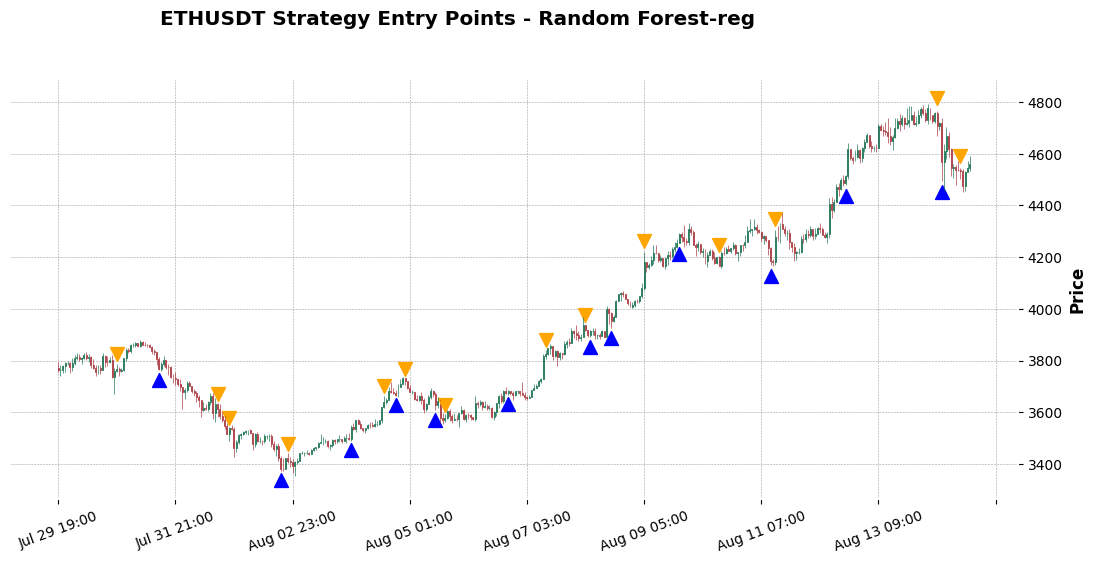

In [7]:
start_dt = '2025-07-20 00:00:00'
end_dt = '2025-08-15 00:00:00'

plot_signals(df=df, start=start_dt, end=end_dt, symbol=symbol, strategy_name='Random Forest-reg')

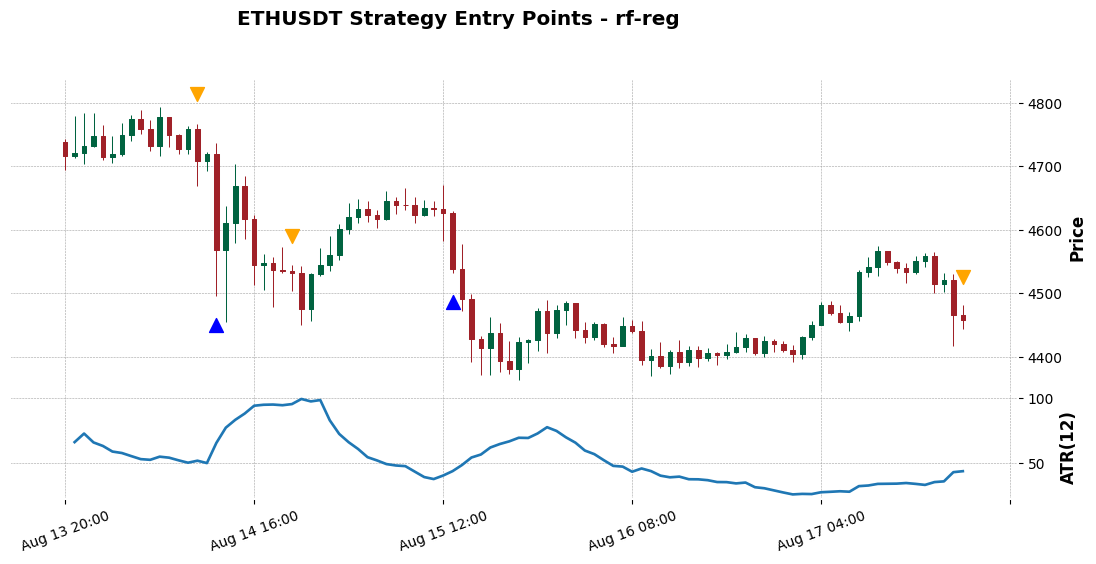

In [8]:
plot_recent_signals(limit=4*24)

### Run backtest

#### ATR dynamic

In [9]:
strategy_params = dict(
        atr_period=8,
        atr_tp_factor=1.5,
        atr_sl_factor=1.5,
        signal_column='final_signal'
    )

In [10]:
results = run_backtest(strategy_class=AtrDynamicStopStrategy,
             signals_df=df, 
             strategy_params=strategy_params,
             )

2025-07-30T20:00:00 - 开空仓 @ 3768.65 (TP=3695.30, SL=3842.00)
2025-07-31T00:00:00 - 空头止损 @ 3842.00
2025-07-31T14:00:00 - 开多仓 @ 3766.59 (TP=3813.19, SL=3719.99)
2025-07-31T16:00:00 - 多头止盈 @ 3813.19
2025-08-01T15:00:00 - 开空仓 @ 3614.49 (TP=3534.62, SL=3694.36)
2025-08-01T19:00:00 - 空头止盈 @ 3534.62
2025-08-01T20:00:00 - 开空仓 @ 3539.90 (TP=3463.09, SL=3616.71)
2025-08-01T22:00:00 - 空头止盈 @ 3463.09
2025-08-02T18:00:00 - 开多仓 @ 3382.05 (TP=3447.43, SL=3316.67)
2025-08-02T21:00:00 - 反转做空：平多仓 @ 3410.92
2025-08-04T00:00:00 - 开多仓 @ 3543.90 (TP=3587.47, SL=3500.33)
2025-08-04T13:00:00 - 多头止盈 @ 3587.47
2025-08-04T14:00:00 - 开空仓 @ 3637.98 (TP=3590.94, SL=3685.02)
2025-08-04T16:00:00 - 空头止损 @ 3685.02
2025-08-04T19:00:00 - 开多仓 @ 3668.14 (TP=3715.15, SL=3621.13)
2025-08-04T21:00:00 - 多头止盈 @ 3715.15
2025-08-04T23:00:00 - 开空仓 @ 3719.42 (TP=3671.56, SL=3767.28)
2025-08-05T02:00:00 - 空头止盈 @ 3671.56
2025-08-05T12:00:00 - 开多仓 @ 3626.88 (TP=3683.35, SL=3570.41)
2025-08-05T14:00:00 - 多头止损 @ 3570.41
2025-08-05T16:00

In [11]:
print_bt_evals(bt_strat=results[0])

Sharpe Ratio: 0.14396097912479128
Max Drawdown: 5.78%
Total Return: 5.26%, Annual Return: 94.10%
AutoOrderedDict([('total',
                  AutoOrderedDict({'total': 23, 'open': 0, 'closed': 23})),
                 ('streak',
                  AutoOrderedDict([('won',
                                    AutoOrderedDict([('current', 0),
                                                     ('longest', 5)])),
                                   ('lost',
                                    AutoOrderedDict([('current', 2),
                                                     ('longest', 3)]))])),
                 ('pnl',
                  AutoOrderedDict([('gross',
                                    AutoOrderedDict([('total',
                                                      7682.330000000005),
                                                     ('average',
                                                      334.0143478260872)])),
                                   ('net',
        

#### ATR long only

In [12]:
strategy_params = dict(
        atr_period=12,
        atr_tp_factor=1.5,
        atr_sl_factor=1.5,
        signal_column='final_signal'
    )

In [13]:
results = run_backtest(strategy_class=AtrLongOnlyStrategy,
             signals_df=df, 
             strategy_params=strategy_params,
             )

2025-07-31T14:00:00 - Opening long position @ 3766.59 (TP=3814.23, SL=3718.95)
2025-07-31T16:00:00 - Taking profit @ 3814.23
2025-07-31T17:00:00 - Skipping trade with size 0 (possibly invalid)
2025-08-02T18:00:00 - Opening long position @ 3382.05 (TP=3445.75, SL=3318.35)
2025-08-03T03:00:00 - Taking profit @ 3445.75
2025-08-03T04:00:00 - Skipping trade with size 0 (possibly invalid)
2025-08-04T00:00:00 - Opening long position @ 3543.90 (TP=3587.02, SL=3500.78)
2025-08-04T13:00:00 - Taking profit @ 3587.02
2025-08-04T14:00:00 - Skipping trade with size 0 (possibly invalid)
2025-08-04T19:00:00 - Opening long position @ 3668.14 (TP=3714.06, SL=3622.22)
2025-08-04T21:00:00 - Taking profit @ 3714.06
2025-08-04T22:00:00 - Skipping trade with size 0 (possibly invalid)
2025-08-05T12:00:00 - Opening long position @ 3626.88 (TP=3680.17, SL=3573.59)
2025-08-05T14:00:00 - Stop loss @ 3573.59
2025-08-05T15:00:00 - Skipping trade with size 0 (possibly invalid)
2025-08-06T19:00:00 - Opening long posi

In [14]:
print_bt_evals(bt_strat=results[0])

Sharpe Ratio: 0.3373182757462181
Max Drawdown: 2.70%
Total Return: 10.39%, Annual Return: 270.53%
AutoOrderedDict([('total',
                  AutoOrderedDict({'total': 12, 'open': 0, 'closed': 12})),
                 ('streak',
                  AutoOrderedDict([('won',
                                    AutoOrderedDict([('current', 0),
                                                     ('longest', 4)])),
                                   ('lost',
                                    AutoOrderedDict([('current', 1),
                                                     ('longest', 1)]))])),
                 ('pnl',
                  AutoOrderedDict([('gross',
                                    AutoOrderedDict([('total',
                                                      12222.590000000053),
                                                     ('average',
                                                      1018.5491666666711)])),
                                   ('net',
     